In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt # Esta libreria es la que maneja las transformadas
import pywt.data
from scipy import signal
from scipy.ndimage import gaussian_filter

In [2]:
# Cargar imagen y simular desenfoque
original = pywt.data.camera()

In [4]:
# Simular desenfoque con un kernel gaussiano
kernel_size = 15
sigma = 3
blur_kernel = np.zeros((kernel_size, kernel_size))
for i in range(kernel_size):
    for j in range(kernel_size):
        dist = np.sqrt((i - kernel_size//2)**2 + (j - kernel_size//2)**2)
        blur_kernel[i, j] = np.exp(-dist**2 / (2*sigma**2))
blur_kernel = blur_kernel / np.sum(blur_kernel)

In [11]:
# Aplicar el desenfoque a la imagen original
blurred = signal.convolve2d(original, blur_kernel, mode='same', boundary='wrap')


In [5]:
# Función de soft thresholding para los coeficientes wavelet
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [19]:
def admm_wavelet_deblur(blurred_img, kernel, wavelet='bior1.3', lambda_param=0.1, rho=1.0, iterations=200):
    # 1. Transformada wavelet, con la libreria
    coeffs = pywt.dwt2(blurred_img, wavelet)
    LL, (LH, HL, HH) = coeffs

    # Preparar el kernel en el dominio de frecuencia, estos dominios son aquellos
    # donde se aplica cada transformada, eso fue lo que entendi en un paper.
    kernel_fft = np.fft.fft2(kernel, s=blurred_img.shape)
    kernel_conj_fft = np.conjugate(kernel_fft)

    # Variables ADMM, para correr la función, también son nuestras varibles objetivo
    x = blurred_img.copy()
    z = x.copy()
    u = np.zeros_like(x)

    for _ in range(iterations):
        # x-update (minimiza ||Hx - y||^2 + rho/2||x - z + u||^2)
        x_plus_u_fft = np.fft.fft2(z - u)
        numerator = kernel_conj_fft * np.fft.fft2(blurred_img) + rho * x_plus_u_fft
        denominator = np.abs(kernel_fft)**2 + rho
        x = np.real(np.fft.ifft2(numerator / denominator))

        # z-update con soft thresholding en dominio wavelet
        x_plus_u = x + u
        coeffs_x = pywt.dwt2(x_plus_u, wavelet)
        LL_x, (LH_x, HL_x, HH_x) = coeffs_x

        # Aplicar soft thresholding solo a los detalles
        LH_z = soft_threshold(LH_x, lambda_param/rho)
        HL_z = soft_threshold(HL_x, lambda_param/rho)
        HH_z = soft_threshold(HH_x, lambda_param/rho)

        # Reconstruir con coeficientes procesados
        z = pywt.idwt2((LL_x, (LH_z, HL_z, HH_z)), wavelet)

        # u-update
        u = u + (x - z)

    return z

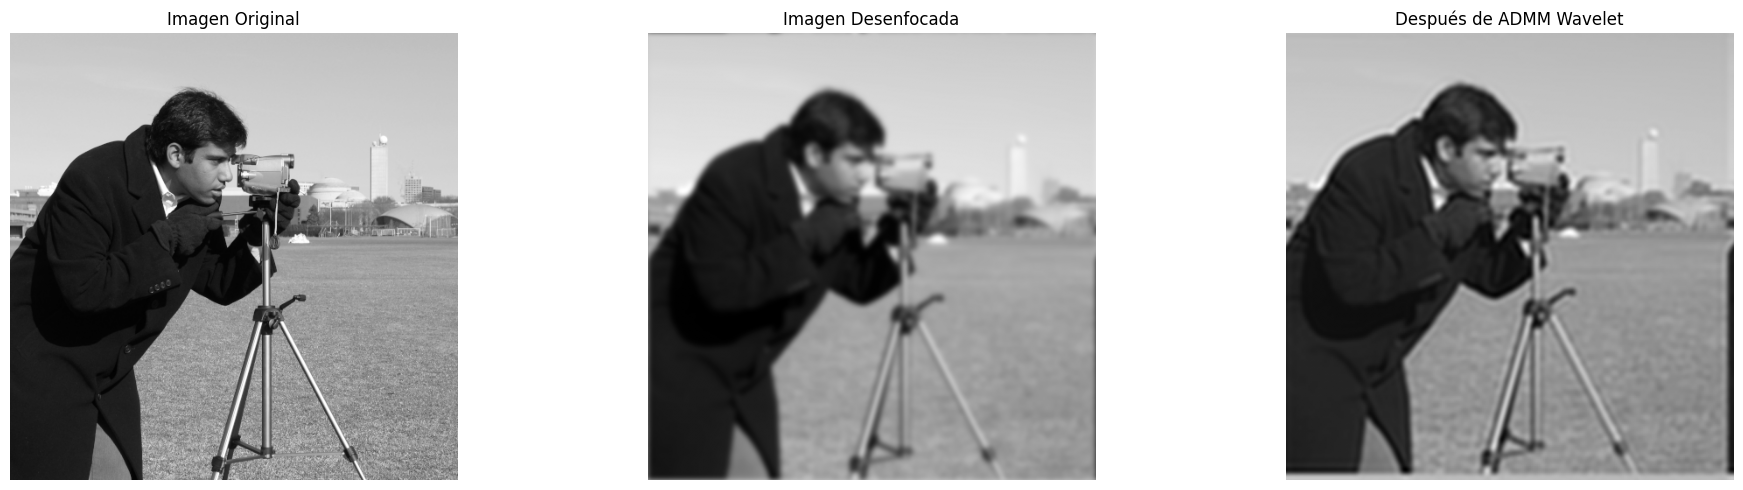

In [15]:
# Ejecutar pipeline completo
# 1. Aplicar ADMM con soft thresholding en dominio wavelet
deblurred_admm = admm_wavelet_deblur(blurred, blur_kernel, lambda_param=0.05)

# Mostrar resultados
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title('Imagen Desenfocada')
axes[1].axis('off')

axes[2].imshow(deblurred_admm, cmap='gray')
axes[2].set_title('Después de ADMM Wavelet')
axes[2].axis('off')



plt.tight_layout()
plt.show()